In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install xgboost

In [ ]:
df = pd.read_csv("/content/drive/My Drive/loan.csv", low_memory=False)
df.head(3)

id  member_id  ...  settlement_percentage  settlement_term
0 NaN        NaN  ...                    NaN              NaN
1 NaN        NaN  ...                    NaN              NaN
2 NaN        NaN  ...                    NaN              NaN

[3 rows x 145 columns]

In [ ]:
df.shape

(2260668, 145)

In [ ]:
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})

In [ ]:
df_null[df_null['Count'] > 0] 

Count     Percent
id                     2260668  100.000000
member_id              2260668  100.000000
emp_title               166969    7.385826
emp_length              146907    6.498389
annual_inc                   4    0.000177
...                        ...         ...
settlement_status      2227612   98.537777
settlement_date        2227612   98.537777
settlement_amount      2227612   98.537777
settlement_percentage  2227612   98.537777
settlement_term        2227612   98.537777

[113 rows x 2 columns]

In [ ]:
df1 = df.dropna(axis=1, thresh=int(0.80*len(df)))    #dropping coluns which has 80% and high na values

In [ ]:
df1.head(5)

loan_amnt  funded_amnt  ...  disbursement_method debt_settlement_flag
0       2500         2500  ...                 Cash                    N
1      30000        30000  ...                 Cash                    N
2       5000         5000  ...                 Cash                    N
3       4000         4000  ...                 Cash                    N
4      30000        30000  ...                 Cash                    N

[5 rows x 87 columns]

In [ ]:
df_LC = df1.filter(['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership',
                    'annual_inc','verification_status','purpose','dti','delinq_2yrs','loan_status'])   #getting the important features for our analysis
df_LC.dtypes

loan_amnt                int64
term                    object
int_rate               float64
installment            float64
grade                   object
sub_grade               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
dti                    float64
delinq_2yrs            float64
loan_status             object
dtype: object

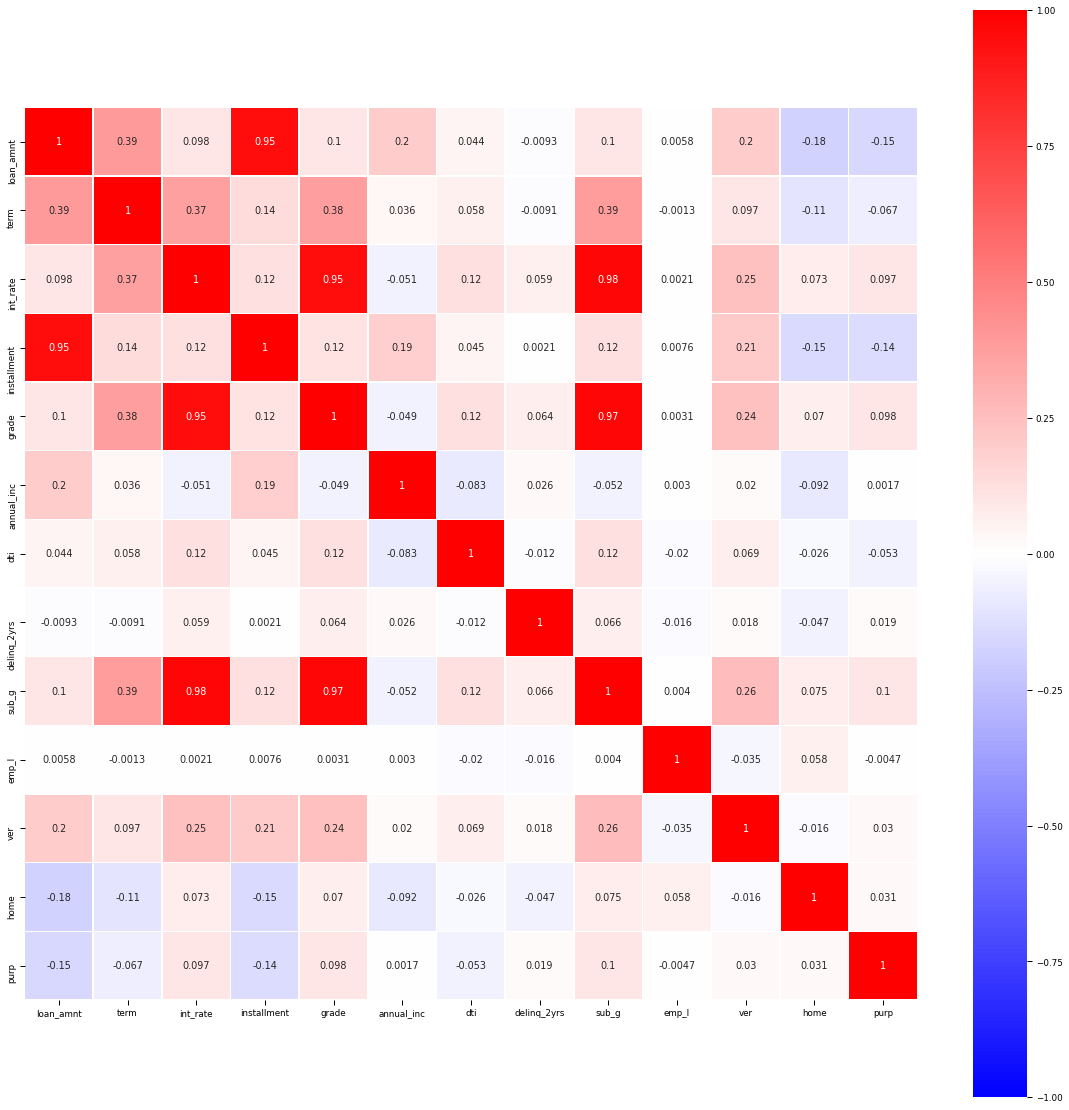

In [ ]:
plt.figure(figsize=(20,20))
sns.set_context("paper", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(grade=df_LC.grade.astype('category').cat.codes,
                         sub_g=df_LC.sub_grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                        emp_l=df_LC.emp_length.astype('category').cat.codes,
                         ver =df_LC.verification_status.astype('category').cat.codes,
                        home=df_LC.home_ownership.astype('category').cat.codes,
                        purp=df_LC.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

In [ ]:
df_LC.drop(['installment','grade','sub_grade','verification_status','term']
           , axis=1, inplace = True)   #dropping the unnecessary features

In [ ]:
dflc_null = pd.DataFrame({'Count': df_LC.isnull().sum(), 'Percent': 100*df_LC.isnull().sum()/len(df_LC)})
dflc_null[dflc_null['Count'] > 0]

Count   Percent
emp_length   146907  6.498389
annual_inc        4  0.000177
dti            1711  0.075686
delinq_2yrs      29  0.001283

In [ ]:
df1_LC = df_LC.dropna(axis=0) #dropping all the rows which contains null value

In [ ]:
df1_LC.isnull()

loan_amnt  int_rate  emp_length  ...    dti  delinq_2yrs  loan_status
0            False     False       False  ...  False        False        False
1            False     False       False  ...  False        False        False
2            False     False       False  ...  False        False        False
3            False     False       False  ...  False        False        False
4            False     False       False  ...  False        False        False
...            ...       ...         ...  ...    ...          ...          ...
2260662      False     False       False  ...  False        False        False
2260663      False     False       False  ...  False        False        False
2260664      False     False       False  ...  False        False        False
2260665      False     False       False  ...  False        False        False
2260667      False     False       False  ...  False        False        False

[2113619 rows x 9 columns]

In [ ]:
len(df1_LC) - df1_LC.count() #checking the null values

loan_amnt         0
int_rate          0
emp_length        0
home_ownership    0
annual_inc        0
purpose           0
dti               0
delinq_2yrs       0
loan_status       0
dtype: int64

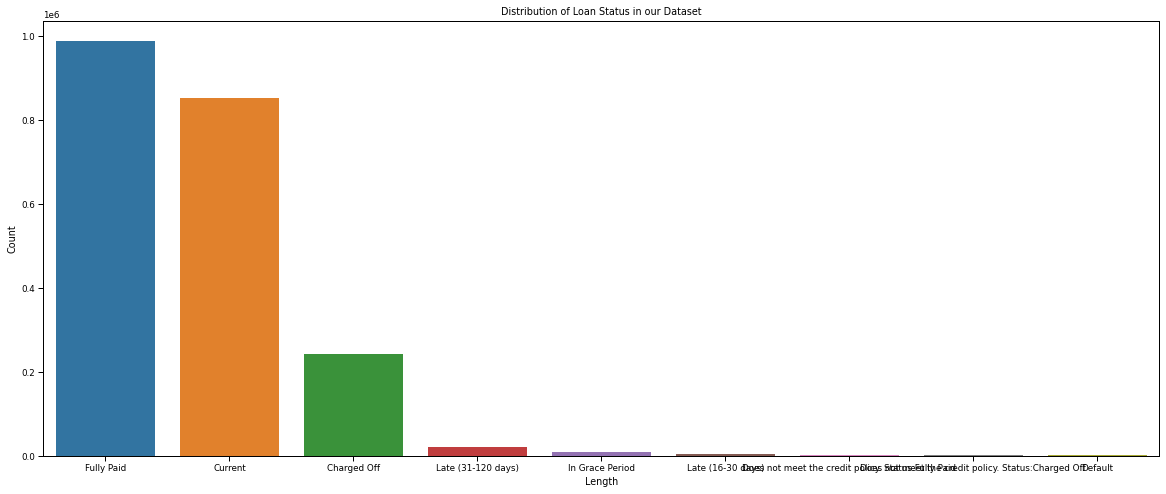

In [ ]:
m =df1_LC['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()     #ploting an histogram of values against count of times the status appears on the dataframe



In [ ]:
df1_LC = df1_LC[df1_LC.loan_status != 'Current']
df1_LC = df1_LC[df1_LC.loan_status != 'In Grace Period']
df1_LC = df1_LC[df1_LC.loan_status != 'Late (16-30 days)']
df1_LC = df1_LC[df1_LC.loan_status != 'Late (31-120 days)']
df1_LC = df1_LC[df1_LC.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
df1_LC = df1_LC[df1_LC.loan_status != 'Does not meet the credit policy. Status:Charged Off']
df1_LC = df1_LC[df1_LC.loan_status != 'Issued']


In [ ]:
df1_LC['loan_status'] = df1_LC['loan_status'].replace({'Charged Off':'Default'})
df1_LC['loan_status'].value_counts()

Fully Paid    986880
Default       241287
Name: loan_status, dtype: int64

In [ ]:
df1_LC.loan_status=df1_LC.loan_status.astype('category').cat.codes
df1_LC.delinq_2yrs=df1_LC.delinq_2yrs.astype('category').cat.codes
df1_LC.head()
df1_LC['loan_status'].value_counts()


1    986880
0    241287
Name: loan_status, dtype: int64

In [ ]:
df1_LC.head(5)

loan_amnt  int_rate emp_length  ...    dti  delinq_2yrs loan_status
100      30000     22.35    5 years  ...  30.46            0           1
152      40000     16.14   < 1 year  ...  50.53            0           1
170      20000      7.56  10+ years  ...  18.92            0           1
186       4500     11.31  10+ years  ...   4.64            0           1
215       8425     27.27    3 years  ...  12.37            0           1

[5 rows x 9 columns]

In [ ]:
df1_LC.head(5)

loan_amnt  int_rate emp_length  ...    dti  delinq_2yrs loan_status
100      30000     22.35    5 years  ...  30.46            0           1
152      40000     16.14   < 1 year  ...  50.53            0           1
170      20000      7.56  10+ years  ...  18.92            0           1
186       4500     11.31  10+ years  ...   4.64            0           1
215       8425     27.27    3 years  ...  12.37            0           1

[5 rows x 9 columns]

In [ ]:
df1_LC = pd.get_dummies(df1_LC, drop_first=True)

In [ ]:
df1_LC.head(5)

loan_amnt  int_rate  ...  purpose_vacation  purpose_wedding
100      30000     22.35  ...                 0                0
152      40000     16.14  ...                 0                0
170      20000      7.56  ...                 0                0
186       4500     11.31  ...                 0                0
215       8425     27.27  ...                 0                0

[5 rows x 34 columns]

In [ ]:
df1_LC.shape

(1228167, 34)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    
        

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df1_LC.drop('loan_status',axis=1),df1_LC['loan_status'],test_size=0.4,random_state=101)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [ ]:
from imblearn.over_sampling import SMOTE #using SMOTE to balance the training data

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1109) #Running the KNN algorithm
knn.fit(x_train_r,y_train_r)

In [ ]:
print_score(knn, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
gnb = GaussianNB() #Running the Gaussian Naive Bayes model
gnb.fit(x_train_r,y_train_r)

In [ ]:
print_score(knn, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
#Running the Decision Tree Algorithm
dt_clf = DecisionTreeClassifier(n_estimators=40, random_state=21)
dt_clf = clf.fit(x_train_r,y_train_r)
print_score(dt_clf, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
#finding the best hyperparameter for decision tree algorithm
sample_split_range = list(range(1, 50))
param_grid = dict(min_samples_split=sample_split_range)
grid = GridSearchCV(dt_clf, param_grid, cv=10, scoring='accuracy')
grid.fit(x_train_r, y_train_r)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
xgb = XGBClassifier() #Running XGBoost Algorithm
xgb.fit(x_train_r,y_train_r)
print_score(xgb, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
#Running the Decision Tree Algorithm
dt_clf = DecisionTreeClassifier(random_state=21)
dt_clf = dt_clf.fit(x_train_r,y_train_r)
print_score(dt_clf, x_train_r, y_train_r, X_test, y_test, train=False)


In [ ]:
#finding the best hyperparameter for decision tree algorithm
sample_split_range = list(range(2, 50))
param_grid = dict(min_samples_split=sample_split_range)
grid = GridSearchCV(dt_clf, param_grid, cv=10, scoring='accuracy')
grid.fit(x_train_r, y_train_r)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
gnb = GaussianNB() #Running the Gaussian Naive Bayes model
gnb.fit(x_train_r,y_train_r)
print_score(gnb, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1109) #Running the KNN algorithm
knn.fit(x_train_r,y_train_r)
print_score(knn, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
#Running the Decision Tree Algorithm with gridsearch
dt_clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=80, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=49,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')
dt_clf = dt_clf.fit(x_train_r,y_train_r)
print_score(dt_clf, x_train_r, y_train_r, X_test, y_test, train=False)

In [ ]:
xgb = XGBClassifier(learning_rate=1, max_depth=5,gamma=1,min_child_weight=2,nthread=3,n_estimators=1000) #Running XGBoost Algorithm
xgb.fit(x_train_r,y_train_r)
print_score(xgb, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.7856

Classification Report: 
               precision    recall  f1-score   support

           0       0.38      0.14      0.21     72536
           1       0.82      0.94      0.88    295915

    accuracy                           0.79    368451
   macro avg       0.60      0.54      0.54    368451
weighted avg       0.73      0.79      0.74    368451


Confusion Matrix: 
 [[ 10301  62235]
 [ 16779 279136]]



In [ ]:

from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
filename = 'xgboost_model.pkl'
joblib.dump(xgb, filename)

['xgboost_model.pkl']

ERROR: unknown command "update"


NameError: ignored

NameError: ignored